In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import yfinance as yf
import pandas as pd
from sklearn.metrics import r2_score,root_mean_squared_error


device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

bitcoin = yf.download("BTC-USD",start="2010-05-10",end="2025-09-05")['Close']
bitcoin = bitcoin.dropna()
bitcoin = bitcoin.reset_index()


cuda:0


/tmp/ipykernel_42560/3000174542.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bitcoin = yf.download("BTC-USD",start="2010-05-10",end="2025-09-05")['Close']
[*********************100%***********************]  1 of 1 completed


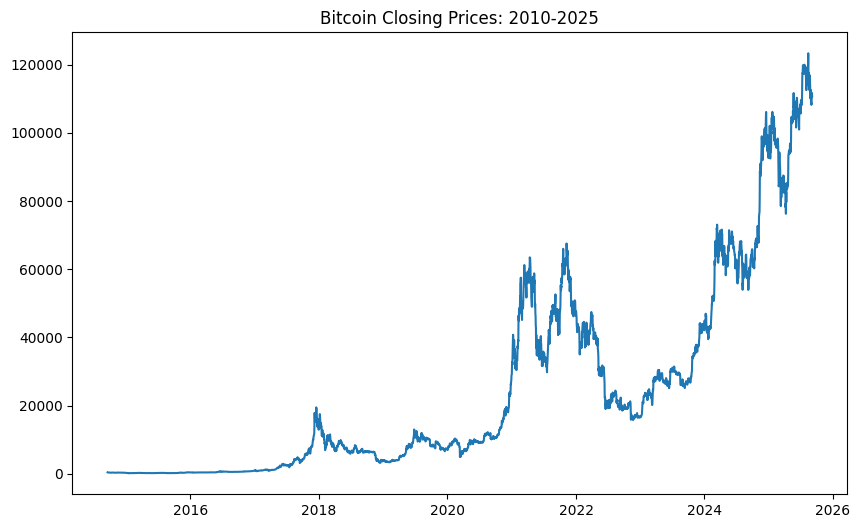

In [2]:
plt.figure(figsize=(10,6))
plt.plot(bitcoin['Date'],bitcoin['BTC-USD'])
plt.title("Bitcoin Closing Prices: 2010-2025")
plt.savefig("images/closing_prices.png")
plt.show()

In [3]:

training = bitcoin.iloc[:,1:2].values

train_size = int(len(training)* 0.80)

train_data = training[:train_size]
test_data = training[train_size:]
print(len(train_data))
print(len(test_data))

3204
802


In [4]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length):
        Xi = dataframe[i:(seq_length + i)]
        yi = dataframe[(seq_length + i)]
        X.append(Xi)
        y.append(yi)
    return np.array(X),np.array(y)

seq_length = 1
X_train,y_train = slider(train_data,seq_length)
X_test,y_test = slider(test_data,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()



In [5]:


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(self.input_size, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out



input_size = 1
hidden_size = 256
num_layers = 1
output_size = 1
learning_rate= 0.001


model = GRU(input_size,hidden_size,num_layers,output_size)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

/tmp/ipykernel_42560/2463205465.py:42: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_42560/2463205465.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.2696; Test RSME: 1.034
Epoch: 1; train_RSEM: 0.2622; Test RSME: 1.016
Epoch: 2; train_RSEM: 0.2553; Test RSME: 0.9986
Epoch: 3; train_RSEM: 0.249; Test RSME: 0.9811
Epoch: 4; train_RSEM: 0.2433; Test RSME: 0.9638
Epoch: 5; train_RSEM: 0.2382; Test RSME: 0.9465
Epoch: 6; train_RSEM: 0.2337; Test RSME: 0.9295
Epoch: 7; train_RSEM: 0.2299; Test RSME: 0.9126
Epoch: 8; train_RSEM: 0.2266; Test RSME: 0.8961
Epoch: 9; train_RSEM: 0.2239; Test RSME: 0.8799
Epoch: 10; train_RSEM: 0.2216; Test RSME: 0.8642
Epoch: 11; train_RSEM: 0.2198; Test RSME: 0.8491
Epoch: 12; train_RSEM: 0.2184; Test RSME: 0.8346
Epoch: 13; train_RSEM: 0.2172; Test RSME: 0.821
Epoch: 14; train_RSEM: 0.2161; Test RSME: 0.8082
Epoch: 15; train_RSEM: 0.215; Test RSME: 0.7964
Epoch: 16; train_RSEM: 0.2139; Test RSME: 0.7856
Epoch: 17; train_RSEM: 0.2127; Test RSME: 0.7759
Epoch: 18; train_RSEM: 0.2113; Test RSME: 0.7672
Epoch: 19; train_RSEM: 0.2098; Test RSME: 0.7595
Epoch: 20; train_RSEM: 0.208; Test 

In [6]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)








test_dates = bitcoin.iloc[train_size + seq_length:]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Price": actual_rescaled.flatten(),
    "Predicted Price": pred_rescaled.flatten()
})


rmse = root_mean_squared_error(y_test_np,pred_np)
r2 = r2_score(y_test_np,pred_np)
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R2-Score: {r2*100:.2f}%')

print(comparison_df.head(20))
print(comparison_df.tail(20))


Root Mean Squared Error: 0.0286
R2-Score: 99.53%
         Date  Actual Price  Predicted Price
0  2023-06-27  30688.164062     30153.136719
1  2023-06-28  30086.246094     30571.421875
2  2023-06-29  30445.351562     29967.730469
3  2023-06-30  30477.251953     30327.867188
4  2023-07-01  30590.078125     30359.863281
5  2023-07-02  30620.769531     30473.033203
6  2023-07-03  31156.441406     30503.820312
7  2023-07-04  30777.583984     31041.232422
8  2023-07-05  30514.167969     30661.121094
9  2023-07-06  29909.337891     30396.888672
10 2023-07-07  30342.265625     29790.343750
11 2023-07-08  30292.541016     30224.478516
12 2023-07-09  30171.234375     30174.609375
13 2023-07-10  30414.470703     30052.953125
14 2023-07-11  30620.951172     30296.896484
15 2023-07-12  30391.646484     30503.998047
16 2023-07-13  31476.050781     30274.003906
17 2023-07-14  30334.070312     31361.960938
18 2023-07-15  30295.806641     30216.255859
19 2023-07-16  30249.132812     30177.882812
      

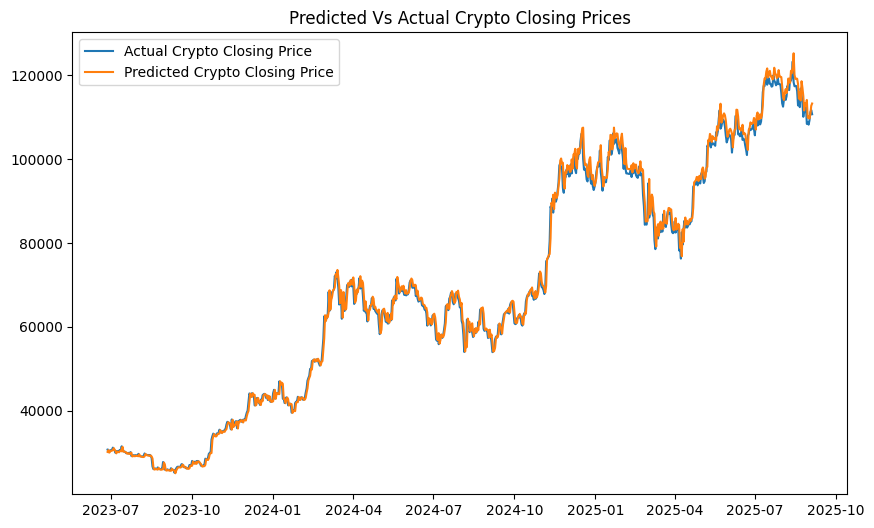

In [7]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df['Actual Price'],label="Actual Crypto Closing Price")
plt.plot(comparison_df['Date'],comparison_df['Predicted Price'],label="Predicted Crypto Closing Price")
plt.title("Predicted Vs Actual Crypto Closing Prices")
plt.savefig("images/predicted-vs-actual-closing-prices-btc.png")
plt.legend()
plt.show()





